In [1]:
import sys
import os.path
import numpy as np
from landlab import imshow_grid
from landlab import RasterModelGrid
from matplotlib import pyplot as plt

#use the utility functions
utilspath=os.path.join("..","util")
sys.path = [utilspath]+sys.path
import myLandlabTools as tools

# path with topography dem data
topopath=os.path.join("..","topographies")

%matplotlib inline

In [2]:
roughnessDict = {
    'm1': [0.05],
}


# soil infiltration [min, max]
# lower value means lower infiltration
hydCondDict = {
            '4e-6 m/s':[4e-6, 4.5e-6],     
            '4.5e-6 m/s':[4.5e-6, 5e-6],     
            '5e-6 m/s':[5e-6, 5.5e-6],     
            '5.5e-6 m/s':[5.5e-6, 6e-6],        
}
# from Gowdish & Munoz                               # from Carsel & Parrish
# hydCondDict = {
#             'cond1' :[1.7e-7, 'clay'],
#             'cond2' :[2.7e-7, 'silty clay'],
#             'cond3' :[3.3e-7, 'sandy clay'],
#             'cond4' :[5.5e-7, 'silty clay loam'],
#             'cond5' :[5.5e-7, 'clay loam'],          # 7.17e-7
#             'cond6' :[8.3e-7, 'sandy clay loam'],
#             'cond7' :[1.8e-6, 'silt loam' ],         # 1.25e-6
#             'cond8' :[3.6e-6, 'loam'],               # 2.88e-6
#             'cond9' :[6.1e-6, 'sandy loam' ],        # 1.23e-5 
#             'cond10':[1.6e-5, 'loamy sand'],      
#             'cond11':[6.5e-5, 'sand' ],              # 8.25e-5  
# }

soilType = ['sandy loam']

# Water column height above the surface previously absorbed into the soil.
# Do NOT set to zero
soilWaterInfiltrationDepth = 0.15
    
dem = 'clipped2cropped2.asc'
boundary = 'noData'   
noDataValue = -99999
outletNode = 3242
monitorLink = 6352 
showProgress = False
showPlots = False   

# The dash list is a even size list that gives the ink on, ink off in pixels.
dashList = [(3,0),(1,1),(3,3),(7,7),(7,2),(5,2,2,2,5,2),(2,2,7,2,2,2),(3,3,2,2),(5,2,10,2),(10,5,20,5)] 


[-3.38235294 -3.23529412 -3.08823529 -2.94117647 -2.79411765 -2.64705882
 -2.5        -2.35294118 -2.20588235 -2.05882353 -1.91176471 -1.76470588
 -1.61764706 -1.47058824 -1.32352941 -1.17647059 -1.02941176 -0.88235294
 -0.73529412 -0.58823529 -0.44117647 -0.29411765 -0.14705882  0.
  0.14705882  0.29411765  0.44117647  0.58823529  0.73529412  0.88235294
  1.02941176  1.17647059  1.32352941  1.47058824  1.61764706  1.76470588
  1.91176471  2.05882353  2.20588235  2.35294118  2.5         2.64705882
  2.79411765  2.94117647  3.08823529  3.23529412  3.38235294  3.52941176
  3.67647059  3.82352941  3.97058824  4.11764706  4.26470588  4.41176471
  4.55882353  4.70588235  4.85294118  5.          5.14705882]
[ 0.          0.14705882  0.29411765  0.44117647  0.58823529  0.73529412
  0.88235294  1.02941176  1.17647059  1.32352941  1.47058824  1.61764706
  1.76470588  1.91176471  2.05882353  2.20588235  2.35294118  2.5
  2.64705882  2.79411765  2.94117647  3.08823529  3.23529412  3.38235294
  3.

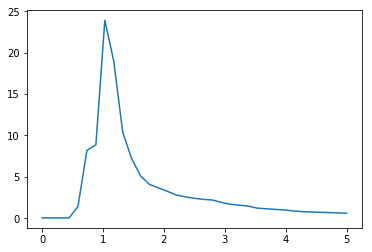

In [15]:
cal = np.loadtxt('../calibrationData/Reworked/flows_20090210.csv')
# print(cal)

q = 5
p = 0
b = 59
a = 25

m = (q-p)/(b-a)
c = q - m*(b-1)

c_time = m*cal[:,0] + c

print(c_time)

vtest = (c_time >=0) & (c_time <=5)
measured_time = c_time[np.where(vtest)]
measured_discharge = cal[np.where(vtest),1]
print(measured_time)
print(measured_discharge)

measured_cum = np.cumsum(np.array(measured_discharge)[0,1:]*np.diff(np.array(measured_time)))*3600.
print(measured_cum)

plt.plot(measured_time,measured_discharge[0])
plt.show()
ln = 'Measured data'


Storm 2009-02-10:
d=0.150|5.000e-06->5.500e-06|m=0.050|Max discharge at outlet = 21.899 m3/s
d=0.150|4.000e-06->4.500e-06|m=0.050|Max discharge at outlet = 28.280 m3/s
d=0.150|4.500e-06->5.000e-06|m=0.050|Max discharge at outlet = 25.248 m3/s
d=0.150|5.500e-06->6.000e-06|m=0.050|Max discharge at outlet = 18.945 m3/s


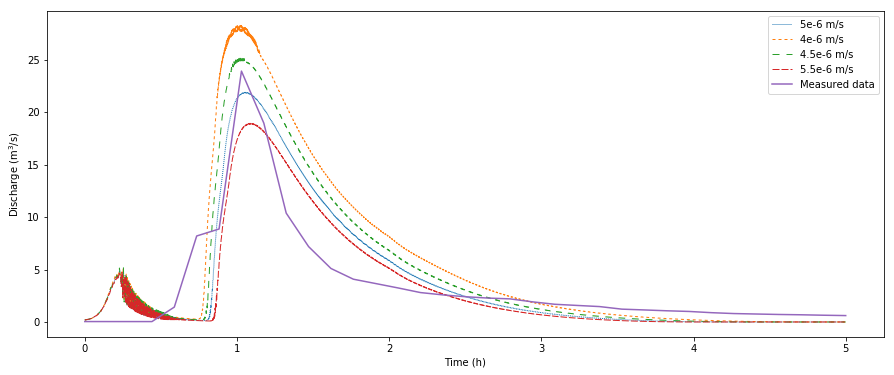

In [10]:
dicCumDist = {}
storms = ['1995-11-18','1997-03-11','2009-02-10','2010-12-08','2012-11-24']
storms = ['2009-02-10']
for i, storm_flag in enumerate(storms):
    dicCumDist[storm_flag] = {}
    print('\nStorm {}:'.format(storm_flag))
    
    if storm_flag == '1995-11-18':
        starting_precip_mmhr = 15.6
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 17100.
        surfaceWaterDepth = 0.02
    elif storm_flag == '1997-03-11':
        starting_precip_mmhr = 34.8
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 4500.
        surfaceWaterDepth = 0.003
    elif storm_flag == '2009-02-10':
        starting_precip_mmhr = 18.
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 7200.
        surfaceWaterDepth = 0.022
    elif storm_flag == '2010-12-08':
        starting_precip_mmhr = 16.8
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 5400.
        surfaceWaterDepth = 0.018
    elif storm_flag == '2012-11-24':
        starting_precip_mmhr = 16.8
        starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
        storm_duration = 3900.
        surfaceWaterDepth = 0.019
    
    runHours = 2.5 * storm_duration/3600.  
    reportInterval = runHours / 4.
    
    plt.figure(i+1,figsize = (15,6))
    theLegend = []
    
    for soil_type in soilType:
        dicCumDist[storm_flag][soil_type] = {}

        # for each hydraulic conductivity
        for m, hyd in enumerate(hydCondDict):
            dicCumDist[storm_flag][soil_type][hyd] = {}
           
            min_h = hydCondDict[hyd][0]
            max_h = hydCondDict[hyd][1]

            # for each roughness value 
            for key in roughnessDict:
                dicCumDist[storm_flag][soil_type][hyd][key] = {}
                mannings_n = roughnessDict[key][0]

                rmg, hydraulic_conductivity, discharge_at_outlet, hydrograph_time, h, d = tools.runModel(
                                        topopath, dem, 
                                        soil_type, min_h, max_h, 
                                        starting_precip_mmhr, storm_duration, 
                                        soilWaterInfiltrationDepth, surfaceWaterDepth,
                                        mannings_n,
                                        boundary, monitorLink,  
                                        runHours, reportInterval,
                                        soilInf = True, sinkFiller = False, 
                                        showProgress = False, showPlots = False,
                                        noDataValue=noDataValue)

                print('d={:.3f}|{:.3e}->{:.3e}|m={:.3f}|Max discharge at outlet = {:.3f} m3/s'.format(soilWaterInfiltrationDepth, min_h, max_h, mannings_n, max(discharge_at_outlet)))
                
                # Hydrograph at the outlet node
                theLegend.append(hyd)
                plt.plot(hydrograph_time, discharge_at_outlet, linewidth=1, dashes=dashList[m+1])
                
                # Cumulative discharge lists
                dicCumDist[storm_flag][soil_type][hyd][key]['time'] = hydrograph_time
                dicCumDist[storm_flag][soil_type][hyd][key]['discharge'] = discharge_at_outlet
                
        plt.plot(measured_time,measured_discharge[0])
        theLegend.append(ln)
                
        plt.legend(theLegend) 
        plt.xlabel('Time (h)')
        plt.ylabel('Discharge (m$^3$/s)')
#         plt.savefig('hydrograph.png', dpi=300)



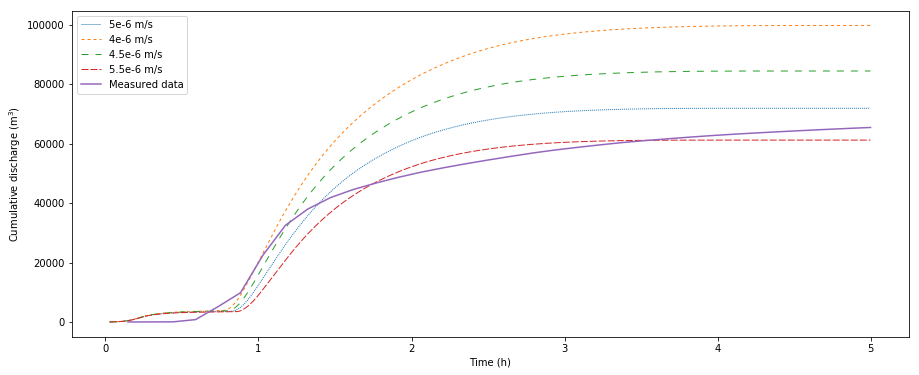

In [18]:
# Cumulative water flow at outlet node
for i, storm_flag in enumerate(storms):
    
    plt.figure(i+1,figsize = (15,6))
    theLegend = []
    
    for soil_type in soilType:
        for m, hyd in enumerate(hydCondDict):
            for key in roughnessDict:
                htime = dicCumDist[storm_flag][soil_type][hyd][key]['time'] 
                discharge = dicCumDist[storm_flag][soil_type][hyd][key]['discharge'] 

                tot_volume_mid = np.cumsum(np.array(discharge)[1:]*np.diff(np.array(htime)))*3600.

                theLegend.append(hyd)
                plt.plot(htime[1:], tot_volume_mid, linewidth=1, dashes=dashList[m+1])
                # plt.title('Cumulative water flow')
        
        plt.plot(measured_time[1:],measured_cum)
        theLegend.append(ln)
        
        plt.ylabel('Cumulative discharge (m$^3$)')
        plt.xlabel('Time (h)')
        plt.legend(theLegend)
    # print('Cumulative discharge at the outlet node = {:.3f} m3'.format(sum(np.abs(discharge_at_outlet)[1:]*np.diff(np.array(hydrograph_time))*3600.)))
        plt.savefig('cumWaterFlow.png', dpi=300)
